### **Phase 1: Player Detection and Initial Analysis** 🏃‍♂️⚽️

1. **YOLOv11 Fine-Tuning for Player Detection** 🎯
   - Adapt YOLOv11 for detecting football players on the field.
   - **Objective**: Ensure robust detection of players, even under challenging scenarios like crowded scenes or varying lighting conditions.

In [ ]:
import torch
print(torch.backends.mps.is_available())
print(torch.cuda.is_available())

False
True


In [10]:
!yolo task=detect mode=train model="/content/drive/MyDrive/FootCVision/utils/yolo11s.pt" data="/content/drive/MyDrive/dataset/data.yaml" epochs=10 imgsz=640 device=0

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/FootCVision/utils/yolo11s.pt, data=/content/drive/MyDrive/dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

1.2 **Inference on Youtube Video** !

In [2]:
!yolo task=detect mode=predict model="/Users/alyazouzou/Desktop/CV_Football/FootCVision2/phase1/runs/detect/train/weights/best.pt" source="/Users/alyazouzou/Desktop/CV_Football/vids/demo.mov" device=mps project="/Users/alyazouzou/Desktop/CV_Football/vids" name="output"

Ultralytics 8.3.57 🚀 Python-3.9.21 torch-2.5.1 MPS (Apple M3)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

video 1/1 (frame 1/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 17 players, 1 referee, 188.4ms
video 1/1 (frame 2/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 17 players, 1 referee, 26.0ms
video 1/1 (frame 3/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 18 players, 1 referee, 14.1ms
video 1/1 (frame 4/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 18 players, 1 referee, 15.7ms
video 1/1 (frame 5/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 18 players, 1 referee, 14.6ms
video 1/1 (frame 6/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo.mov: 384x640 1 goalkeeper, 18 players, 1 referee, 19.0ms
video 1/1 (frame 7/3229) /Users/alyazouzou/Desktop/CV_Football/vids/demo

2. **Conformal Object Detection with puncc library** 📏

In [48]:
import os
import glob
import numpy as np
from PIL import Image
from inference import PlayerInference
from odwrapper import YOLOAPIWrapper

from deel.puncc.object_detection import SplitBoxWise
from deel.puncc.metrics import object_detection_mean_coverage, object_detection_mean_area
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

In [49]:
dataset_path = "/Users/alyazouzou/Desktop/CV_Football/dataset"
train_images_path = os.path.join(dataset_path, "train/images")
train_labels_path = os.path.join(dataset_path, "train/labels")

def parse_yolo_dataset(images_path, labels_path, percentage=0.01, random_seed=42):
    """
    Parse a subset of the YOLO dataset (e.g., 1%) and extract image paths, ground truth boxes, and labels.
    Args:
        images_path (str): Path to the images folder.
        labels_path (str): Path to the labels folder.
        percentage (float): Percentage of data to parse (e.g., 0.01 for 1%).
        random_seed (int): Random seed for reproducibility.
    Returns:
        Tuple[List[str], List[np.ndarray], List[List[int]]]: Subsampled image paths, ground truth boxes, and labels.
    """
    # Use glob to get all .txt files
    label_files = glob.glob(os.path.join(labels_path, "*.txt"))

    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Determine the number of files to sample
    total_files = len(label_files)
    sample_size = int(percentage * total_files)

    # Randomly select a subset of files
    sampled_files = np.random.choice(label_files, size=sample_size, replace=False)

    image_paths = []
    ground_truth_boxes = []
    all_labels = []

    for label_file in sampled_files:
        with open(label_file, "r") as f:
            labels = f.readlines()

        # Extract bounding boxes and associated class IDs
        boxes = []
        labels_per_image = []
        for label in labels:
            parts = list(map(float, label.strip().split()))
            class_id, x_center, y_center, width, height = parts
            image_file = os.path.join(images_path, os.path.basename(label_file).replace(".txt", ".jpg"))
            image = Image.open(image_file)
            image_width, image_height = image.size
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height
            # Convert YOLO format to bounding box (x1, y1, x2, y2)
            x1 = x_center - (width / 2)
            y1 = y_center - (height / 2) #ici c'est pas + ? 
            x2 = x_center + (width / 2)
            y2 = y_center + (height / 2) #et ici - ? 
            boxes.append([x1, y1, x2, y2])
            labels_per_image.append(int(class_id))

        # Add the image path, boxes, and labels
        image_file = os.path.join(images_path, os.path.basename(label_file).replace(".txt", ".jpg"))
        image_paths.append(image_file)
        ground_truth_boxes.append(boxes)
        all_labels.append(labels_per_image)

    return image_paths, ground_truth_boxes, all_labels


# Parse the YOLO dataset
image_paths, ground_truth_boxes, all_labels = parse_yolo_dataset(train_images_path, train_labels_path)

# Convert to numpy arrays for compatibility
X = np.array(image_paths)
y = np.array(ground_truth_boxes, dtype=object)  # Use dtype=object for variable-length arrays
labels = np.array(all_labels, dtype=object)  # Use dtype=object for variable-length arrays

# Split the data into training and validation sets
X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(X, y, labels, test_size=0.2, random_state=42)

In [50]:
yolo_apii = YOLOAPIWrapper(model_path="/Users/alyazouzou/Desktop/CV_Football/FootCVision/phase1/runs/detect/train/weights/best.pt")

In [51]:
print(yolo_apii.predict_and_match(X[0], y[0]))


image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/324_jpg.rf.b1c72e3f0c6559a99e19500d21bc8f72.jpg: 640x640 1 ball, 11 players, 2 referees, 89.5ms
Speed: 0.7ms preprocess, 89.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
(array([[     54.713,      242.29,       69.63,      322.99],
       [     119.49,      207.96,      131.28,      279.33],
       [     97.053,       355.1,      124.25,      443.97],
       [     137.88,       176.2,      151.84,      236.13],
       [     183.86,      200.67,      201.01,      266.03],
       [     243.51,      157.12,      256.54,      217.78],
       [      310.8,      272.12,      325.69,      348.07],
       [     271.35,      313.98,      289.86,      394.23],
       [     360.26,      354.23,      381.04,      438.53],
       [     402.26,      208.32,      420.36,       264.4],
       [     524.76,      152.33,      542.07,      216.37],
       [     279.68,      122.63,      292.26,       182.2],
    

In [52]:
from deel.puncc.api.prediction import IdPredictor
from deel.puncc.object_detection import SplitBoxWise

# Create the proxy for the object detection model
api_model = IdPredictor()

In [53]:
# Appel à la méthode query
y_preds, y_trues_matched, images, classes = yolo_apii.query(X_train, y_train, labels_train)

print("Predictions:", y_preds)
print("Matched Ground Truths:", y_trues_matched)
print("Images:", images)
print("Classes:", classes)

Predictions: [[     458.78      444.22      496.91      480.09]
 [     119.95      469.71      266.64      561.45]
 [     21.959      440.71      182.43         640]
 ...
 [     523.17      424.34      534.18       459.9]
 [     408.94      240.86       415.5      268.33]
 [      480.7         358      520.14      416.56]]
Matched Ground Truths: [[        460       443.5         495       478.5]
 [      123.5         470       269.5         566]
 [         26       445.5         181       639.5]
 ...
 [      523.5       423.5       534.5       458.5]
 [        409         241         416         267]
 [      476.5       359.5       519.5       417.5]]
Images: ['/Users/alyazouzou/Desktop/CV_Football/dataset/train/images/d59e4f57115e3317_jpg.rf.0cbb45ffc56fc1d4ef791542eb915b4b.jpg', '/Users/alyazouzou/Desktop/CV_Football/dataset/train/images/481_jpg.rf.ef4169e802ea85babd7f7319c204eb4d.jpg', '/Users/alyazouzou/Desktop/CV_Football/dataset/train/images/1538_jpg.rf.d508abfc6216f6052c0d8d3694

In [54]:
# Instantiate the conformal predictor
conformal_predictor = SplitBoxWise(api_model, method="multiplicative", train=False)

# Fit the conformal predictor, directly provide the predicted bboxes rather than image inputs
conformal_predictor.fit(X_calib=y_preds, y_calib=y_trues_matched)

### Inference on one Test Image

In [78]:
# Select an image from the test dataset
image_path, bboxes, classes = X_val[1], y_val[1], labels_val[1]

# Predict on the image
y_new_api = yolo_apii.predict_from_image(image_path)

# Choose the coverage target 1-alpha
alpha = 0.3

# Inference + UQ
y_pred_new, box_inner, box_outer = conformal_predictor.predict(y_new_api, alpha=alpha)

# Convert the predictions for comparison
classes = [str(class_) for class_ in classes]
image_path=str(image_path)
y_pred_new_t = tuple(map(tuple, y_pred_new))
bboxes_t = tuple(map(tuple, bboxes))
box_inner_t = tuple(map(tuple, box_inner))
box_outer_t= tuple(map(tuple, box_outer))


image 1/1 /Users/alyazouzou/Desktop/CV_Football/dataset/train/images/405_jpg.rf.7352d4ed2e7cae7a7638c39f9f273c4c.jpg: 640x640 1 ball, 18 players, 1 referee, 89.8ms
Speed: 1.3ms preprocess, 89.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


In [82]:
image = Image.open(image_path)

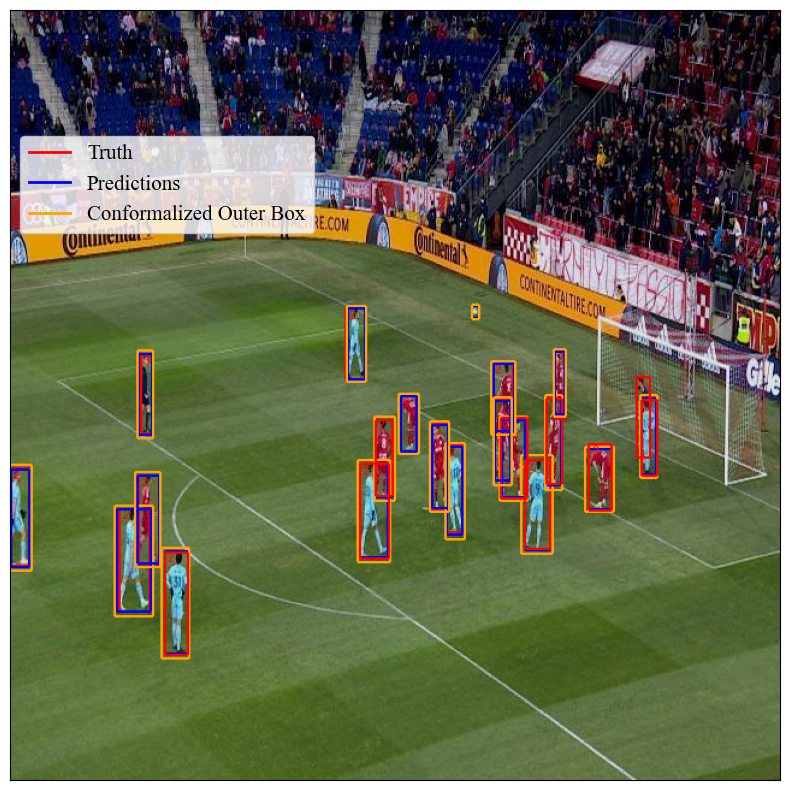

In [83]:
from deel.puncc.plotting import draw_bounding_box

for i in range(len(y_pred_new)):
    image_with_bbox = draw_bounding_box(
        image=image,
        box=bboxes_t[i],
        label=classes[i],
        legend="Truth",
        color="red",
    )
    image_with_bbox = draw_bounding_box(
        image=image,
        box=y_pred_new_t[i],
        legend="Predictions",
        color="blue",
    )
    image_with_bbox = draw_bounding_box(
        image=image,
        box=box_outer_t[i],
        legend="Conformalized Outer Box",
        color="orange",
    )
    
    # image_with_bbox = draw_bounding_box(
    #     image=image_with_bbox,
    #     box=box_inner[i],
    #     legend="Conformalized Inner Box",
    #     color="brown",
    # )

_ = draw_bounding_box(image=image, show=True)

### Inference on All Test Image

In [ ]:
# Evaluate the results
coverage = object_detection_mean_coverage(box_outer, y_test)
average_area = object_detection_mean_area(box_outer)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average area of prediction intervals: {np.round(average_area, 2)}")